# Presentación del Proyecto

Este proyecto es una forma de aprender el abecedario dactilológico.

En el apartado 1. procesa las imágenes a partir de una dataset de fotos de manos.

El apartado 2. crea la Red Neuronal y entrena el modelo. Se puede ejecutar desde el apartado 2. si dispones del dataset en formato .csv

El apartado 3. consiste en a partir del modelo creado (o cargando uno preentrenado), detecta la imagen en tiempo real de la webcam y si detecta una mano predice la letra.

**Advertencia**: 
Por funciones que dependen de librerías, el código solo se puede ejecutar desde la plataforma Google Colab

# 0. Dependencias

Hemos usado las diferentes librerías para Machine Learning como Sklearn, Keras...
También hemos usado la librería Mediapipe para la detección de manos.

In [1]:
#Instala dependencias
!pip install mediapipe

You should consider upgrading via the 'C:\Users\Mattin\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [3]:
# Importa dependencias
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import mediapipe as mp
import pandas as pd
import seaborn as sns

#from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import load_model

from IPython.display import display, clear_output
from PIL import Image
import time

Puedes cargar el dataset desde tu carpeta drive, ejecutando este código.

In [ ]:
# Monta la carpeta de drive donde esta el dataset
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# 1. Procesamiento de Datos

Las imágenes de las manos las hemos sacado de diferentes datasets.

https://www.kaggle.com/bpablo27/abecedario-lenguaje-de-seas-chilenoespaol (Como dataset principal)

https://www.kaggle.com/jordiviader/american-sign-language-alphabet-static

https://www.kaggle.com/danrasband/asl-alphabet-test

https://www.kaggle.com/grassknoted/asl-alphabet

También lo hemos complementado con imágenes echas por nosotros mismos para aumentar en letras que no tenían tantas imágenes.

## Transformación de imagenes

Vamos a aumentar nuestro dataset, modificando ligeramente las imágenes. Con 4 modificaciones multiplicamos por 4 nuestro dataset.

Estas modificaciones no son muy grandes y no alteran mucho la imágen para que el significado no cambie.

In [4]:
# Funciones que transforman la imagen

def perspective_change(img, par1=0.15, par2=0.85):
  num_rows, num_cols = img.shape[:2]
  src_points = np.float32([[0,0], [num_cols-1,0], [0,num_rows-1], [num_cols-1,num_rows-1]])
  dst_points = np.float32([[0,0], [num_cols-1,0], [int(par1*num_cols),num_rows-1], [int(par2*num_cols),num_rows-1]])
  projective_matrix = cv2.getPerspectiveTransform(src_points, dst_points)
  return cv2.warpPerspective(img, projective_matrix, (num_cols,num_rows))

def affine_change(img, par1=0.9, par2=0.1):
  num_rows, num_cols = img.shape[:2]
  src_points = np.float32([[0,0], [num_cols-1,0], [0,num_rows-1]])
  dst_points = np.float32([[0,0], [int(par1*(num_cols-1)),0], [int(par2*(num_cols-1)),num_rows-1]])
  matrix = cv2.getAffineTransform(src_points, dst_points)
  return cv2.warpAffine(img, matrix, (num_rows, num_cols))

def resize_change(img, w=1000, h=900):
  return cv2.resize(img, (w, h), interpolation=cv2.INTER_CUBIC)

## Mostrar imagenes

In [17]:
def img_show(image):
    plt.figure(figsize=(10, 10))
    plt.axis('off')

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.show()

## Funciones para el uso de la librería Mediapipe

Hemos creado varias funciones que usan la librería Mediapipe para un mejor manejo del dataset.

Primero y más importante es crear una función que a partir de una imagen, detecta si hay una mano en ella y si la encuentra, extraiga los diferentes Keypoints de la mano.

Una mano tiene 21 keypoints que identifican las posicion y la forma de la mano y cada dedo. Cada Keypoint tiene 3 coordenadas por lo que podemos representar cada mano por un array de 63 keypoints.

In [9]:
# Modelos mediapipe
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

# Funcion que extrae los keypoints del modulo Mediapipe de cada mano
def extract_keypoints(results):
  return np.array([[res.x, res.y, res.z] for res in results.multi_hand_landmarks[0].landmark]).flatten()

# Funcion que añade a una imagen el recuadro con la prediccion
def show_prediction(image, Ypr='', acc=''):
  # Crea el recuadro y el texto con la prediccion
  cv2.rectangle(image, (0, 0), (120, 120), (245, 117, 16), -1)
  cv2.putText(image, Ypr, (30, 95), cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 255, 255), 2, cv2.LINE_AA)
  cv2.putText(image, acc, (2, 135), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 255, 255), 1)
  # Muestra la imagen con la prediccion
  img_show(image)
  cv2.waitKey(0)
  cv2.destroyAllWindows()

# Funcion que procesa una imagen y detecta si hay una mano
def process_image(image_path='', img=None, show_image=False, static_mode=True):
  with mp_hands.Hands(static_image_mode=static_mode, min_detection_confidence=0.5, min_tracking_confidence=0.5, max_num_hands=1) as hands:
    keypoints = None
    left_hand = None
    image = None

    # Carga la imagen
    if image_path != '':
      image = cv2.imread(image_path)
    elif img is not None:
      image = img
    else:
      return None, None

    # Cambia la imagen para mejor proceso
    image = cv2.flip(image, 1)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Procesa la imagen
    results = hands.process(image_rgb)
    
    # Comprueba si ha detectado una mano
    if results.multi_hand_landmarks is not None:

      # Si detecta que es mano izquierda, flipea para fingir una mano derecha
      if results.multi_handedness[0].classification[0].label == 'Left':
        left_hand = True
        image_rgb = cv2.flip(image_rgb, 1)
        results = hands.process(image_rgb)
      else:
        left_hand = False

      # Volvemos a comprobar que el results no es None
      if results.multi_hand_landmarks is not None:
        # Extrae los keypoints
        keypoints = extract_keypoints(results)
    
        if left_hand is True: image = cv2.flip(image, 1)

        # Dibuja los keypoints sobre la imagen
        for hand_landmarks in results.multi_hand_landmarks:
          mp_drawing.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)

        if left_hand is False: image = cv2.flip(image, 1)

        # Muestra la imagen si el parametro es true
        if show_image == True:
          img_show(image)
          cv2.waitKey(0)
          cv2.destroyAllWindows()

  return keypoints, results, image

## Obtención de keypoints de una imagen (Ejemplo visual)

Por defecto extrae las imágenes desde la carpeta drive. Si quieres puedes cambiar la variable 'data_path', y colocar la ubicación de la carpeta donde tengas el dataset.

Ejemplo mano izquierda:


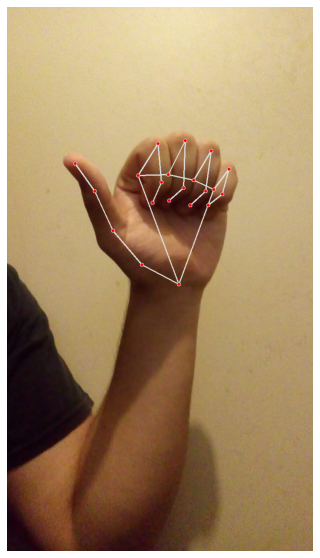

[ 5.61765313e-01  5.09449840e-01 -9.94486754e-07  4.40860003e-01
  4.73608673e-01 -1.23477355e-01  3.46008360e-01  4.11503136e-01
 -1.86389491e-01  2.86240160e-01  3.38735461e-01 -2.34207407e-01
  2.22490996e-01  2.88061500e-01 -2.61929333e-01  4.27977711e-01
  3.09449494e-01 -8.74554366e-02  4.93878394e-01  2.51209259e-01
 -1.63898319e-01  5.05167902e-01  3.22652161e-01 -1.93857059e-01
  4.75108683e-01  3.59464705e-01 -2.04430610e-01  5.26757121e-01
  3.08381200e-01 -5.75877614e-02  5.82919180e-01  2.46027112e-01
 -1.46410197e-01  5.77051342e-01  3.32360059e-01 -1.66107163e-01
  5.29952109e-01  3.55477691e-01 -1.61793157e-01  6.09870374e-01
  3.18131715e-01 -4.30088267e-02  6.67882979e-01  2.64598519e-01
 -1.31313384e-01  6.48958325e-01  3.38607669e-01 -1.09791562e-01
  5.98774195e-01  3.64526361e-01 -7.53194392e-02  6.76078498e-01
  3.35732371e-01 -3.76808867e-02  7.25898266e-01  2.98173875e-01
 -8.74650851e-02  7.03504622e-01  3.44518840e-01 -6.69935569e-02
  6.58330739e-01  3.64608

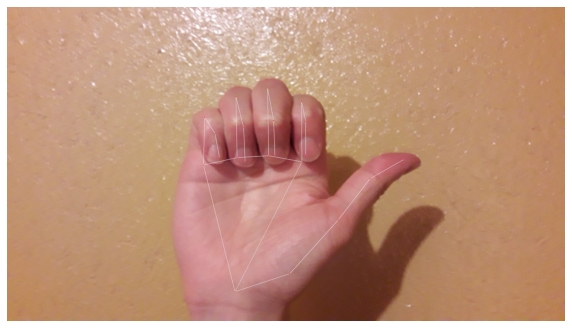

[ 5.91342449e-01  9.06828284e-01 -6.97677990e-07  4.93212163e-01
  8.48883808e-01 -2.87277419e-02  4.06588882e-01  6.78554177e-01
 -3.87677066e-02  3.49402010e-01  5.46702147e-01 -5.39588258e-02
  2.89385647e-01  4.85933721e-01 -6.43584207e-02  4.71497506e-01
  4.92795765e-01  1.24808988e-02  4.71998245e-01  3.01843643e-01
 -3.04602273e-02  4.64709520e-01  3.64517033e-01 -6.09815866e-02
  4.64694798e-01  4.69955772e-01 -7.41623491e-02  5.31229019e-01
  4.73480046e-01  4.62872488e-03  5.33076704e-01  2.57628500e-01
 -4.16168533e-02  5.22256374e-01  3.61750782e-01 -6.55890405e-02
  5.19912839e-01  4.71849084e-01 -6.87102601e-02  5.87496579e-01
  4.79620785e-01 -1.20137930e-02  5.89862883e-01  2.85478950e-01
 -5.37627004e-02  5.75983226e-01  3.84580433e-01 -6.01450093e-02
  5.73309839e-01  4.91331547e-01 -5.13199754e-02  6.47885084e-01
  5.03133118e-01 -3.19856033e-02  6.45717859e-01  3.51269960e-01
 -5.62664196e-02  6.27246857e-01  4.02283967e-01 -5.46225123e-02
  6.19400918e-01  4.79703

In [22]:
drive_path = 'drive/My Drive/Proyecto Deep Learning/dataset'
ejemploIzq = '/E/1f25f60e-7742-42e7-a93d-8884d3bf9472.jpg'
ejemploDch = '/E/20190427_191224.jpg'
ejemploUnd = '/B/20190428_235315.jpg'

print('Ejemplo mano izquierda:')
img1 = cv2.imread(drive_path + ejemploIzq)
keyp1, rs1, im1 = process_image(img=img1, show_image=True)
print(keyp1)

print('Ejemplo mano derecha:')
img2 = cv2.imread(drive_path + ejemploDch)
keyp2, rs2, im2 = process_image(img=img2, show_image=True)
print(keyp2)

print('Ejemplo mano no detectada')
img3 = cv2.imread(drive_path + ejemploUnd)
keyp3, rs3, im3 = process_image(img=img3, show_image=True)
print(keyp3)

## Ejemplo de aumentación de datos

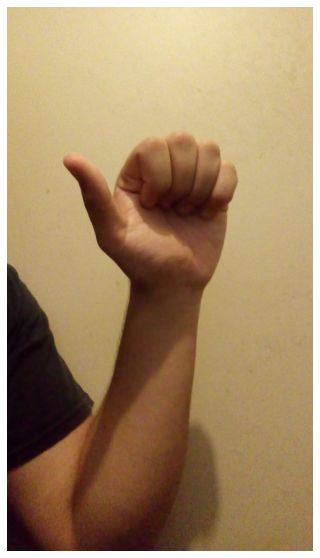

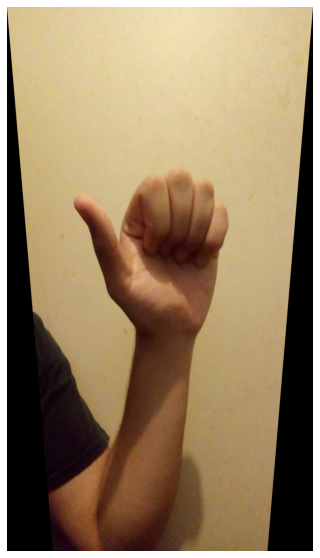

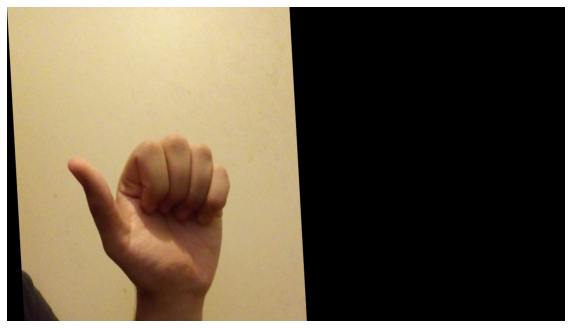

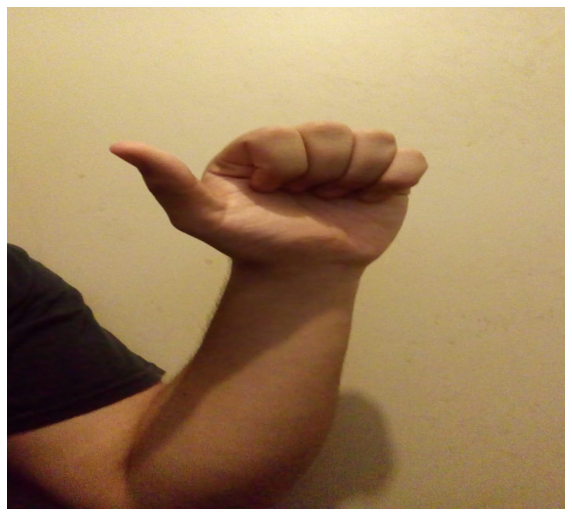

In [20]:
drive_path = 'drive/My Drive/Proyecto Deep Learning/dataset'
ejemploIzq = '/E/1f25f60e-7742-42e7-a93d-8884d3bf9472.jpg'

img = cv2.imread(drive_path + ejemploIzq)
img_show(img)
img_show(perspective_change(img))
img_show(affine_change(img))
img_show(resize_change(img))

## Extrae keypoints del dataset de imágenes

Por defecto extrae las imágenes desde la carpeta drive. Si quieres puedes cambiar la variable 'data_path', y colocar la ubicación de la carpeta donde tengas el dataset.

In [ ]:
# Path de la carpeta
data_path = 'drive/My Drive/Proyecto Deep Learning/dataset'

total_img = 487*4

# Saca cada subcarpeta que será la etiqueta de cada imagen
label_names = os.listdir(data_path)

# Lista con cada keypoint (X) y con cada label (Y)
keypoints = []
label = []

undetected = 0

# Itera cada label
for label_name in label_names:

  # Saca el nombre de cada archivo de imagen
  file_names = os.listdir(data_path + '/' + label_name)

  # Itera cada archivo de imagen
  for file_name in file_names:

    # Crea la direccion para la imagen
    file_path = data_path + '/' + label_name + '/' + file_name

    # Procesa la imagen con sus modificaciones
    img = cv2.imread(file_path)
    imgs = [img]
    imgs.append(perspective_change(img))
    imgs.append(affine_change(img))
    imgs.append(resize_change(img))

    for im in imgs:
      keyp, res, is_left = process_image(img=im)
      if keyp is not None:
        keypoints.append(keyp)
        label.append(label_name)
      else:
        undetected += 1

    # Muestra en pantalla informacion del proceso
    clear_output(wait=True)
    detected = len(label)
    porcentaje = ((detected + undetected) / total_img) * 100
    text = f'Detectadas: {detected} / No detectadas: {undetected} / Porcentaje procesado {porcentaje:.2f}%'
    display(text)

'Detectadas: 1517 / No detectadas: 431 / Porcentaje procesado 100.00%'

Una vez se han procesado todas las imágenes, guardamos el array de keypoints como dataframe en un archivo .csv

In [ ]:
# Convierte las listas con los datos a numpy
X = np.array(keypoints)
Y = np.array(label)
data = np.concatenate((Y.reshape(Y.shape[0], 1), X), axis=1)

# Crea el dataframe con los datos y lo guarda en formato csv
col = [f'Keypoint{x}' if x>0 else 'label' for x in range(64)] 
df = pd.DataFrame(data, columns=col)

df.to_csv('sign_dataset.csv', index=True)

# 2. Red Neuronal

Como nuestro problema es de clasificación, para la red neuronal, hemos decidido crear una red neuronal multicapa.

Partimos de un dataset con 63 parámetros que queremos clasificar a 21 letras diferentes.

Nuestro modelo tendrá 3 capas densas de 64, 32 y finalmente 21 parámetros y una activación de softmax para clasificar entre 21 letras distintas.

## Carga el csv

Cargamos el archivo .csv con las imágenes ya procesadas y convertidas a arrays de keypoints.

Una vez cargado, creamos nuestras variables de entrenamiento y de prueba.

In [24]:
# Carga el archivo csv en un dataframe
df = pd.read_csv('./sign_dataset.csv', index_col=0)

display(df)

# Crea los datos de input de la red neuronal y los separa en train y test
Xn = np.array(df.iloc[:, 1:])
Yn = OneHotEncoder().fit_transform(np.array(df.iloc[:, 0:1])).toarray() # Primera columna es la etiqueta (la letra) de cada fila de datos

X_train, X_test, Y_train, Y_test = train_test_split(Xn, Yn, train_size=0.75)

,label,Keypoint1,Keypoint2,Keypoint3,Keypoint4,Keypoint5,Keypoint6,Keypoint7,Keypoint8,Keypoint9,...,Keypoint54,Keypoint55,Keypoint56,Keypoint57,Keypoint58,Keypoint59,Keypoint60,Keypoint61,Keypoint62,Keypoint63
0,E,0.664310,0.576710,-1.959258e-06,0.469130,0.515484,-0.053939,0.318691,0.419180,-0.087336,...,-0.095649,0.883346,0.274805,-0.147270,0.839790,0.335048,-0.111345,0.802081,0.374503,-0.071974
1,E,0.641171,0.638520,-1.606628e-06,0.472892,0.597894,-0.074366,0.337944,0.497670,-0.111017,...,-0.101852,0.847198,0.355437,-0.164367,0.798521,0.417293,-0.131978,0.763654,0.456672,-0.089689
2,E,0.368265,0.986461,-1.088987e-06,0.268987,0.903578,-0.031521,0.185492,0.729165,-0.047995,...,-0.056939,0.463840,0.486513,-0.083951,0.436619,0.593705,-0.065153,0.419562,0.668855,-0.044762
3,E,0.657593,0.594020,-6.428670e-07,0.500987,0.532291,-0.097402,0.364889,0.439644,-0.162069,...,-0.108096,0.866681,0.277557,-0.153883,0.824808,0.335616,-0.154422,0.776915,0.376466,-0.152649
4,E,0.561768,0.509451,-9.944754e-07,0.440862,0.473610,-0.123484,0.346009,0.411506,-0.186396,...,-0.037667,0.725892,0.298173,-0.087450,0.703499,0.344519,-0.066978,0.658329,0.364607,-0.040640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1512,Y,0.459788,0.714117,-1.612805e-06,0.341995,0.616368,-0.056160,0.257858,0.447465,-0.095519,...,-0.115262,0.783074,0.366778,-0.177076,0.856461,0.299091,-0.193756,0.914963,0.231778,-0.196317
1513,Y,0.525203,0.870728,-9.923042e-07,0.372612,0.778770,-0.087521,0.259608,0.625202,-0.145522,...,-0.077454,0.844542,0.458203,-0.110419,0.888457,0.384919,-0.123706,0.921977,0.307689,-0.122324
1514,Y,0.542588,0.899482,-9.945508e-07,0.414664,0.833417,-0.087843,0.312249,0.689233,-0.139269,...,-0.092461,0.790001,0.527481,-0.153458,0.834226,0.454400,-0.168960,0.873347,0.378999,-0.169703
1515,Y,0.519081,0.862224,-1.253141e-06,0.363820,0.788390,-0.084769,0.268545,0.616025,-0.127503,...,-0.083671,0.816107,0.449648,-0.144499,0.863830,0.375920,-0.162149,0.902207,0.299930,-0.163047


Creamos tambien un array con las diferentes etiquetas para luego hacer las predicciones.

In [25]:
# Nombre de las etiquetas (las letras)
label_names = df['label'].unique()
label_names_sorted = np.sort(label_names)
label_names, label_names_sorted

(array(['E', 'A', 'H', 'B', 'F', 'I', 'L', 'D', 'K', 'C', 'Q', 'N', 'O',
        'U', 'W', 'P', 'M', 'R', 'V', 'T', 'Y'], dtype=object),
 array(['A', 'B', 'C', 'D', 'E', 'F', 'H', 'I', 'K', 'L', 'M', 'N', 'O',
        'P', 'Q', 'R', 'T', 'U', 'V', 'W', 'Y'], dtype=object))

Dimensiones de las variables de entrada y salida.

In [26]:
Xn.shape, Yn.shape

((1517, 63), (1517, 21))

## Red Neuronal Multicapa

### Creación de un modelo Secuencial

Creamos un modelo secuencial como hemos explicado antes. La entrenamos y guardamos el modelo entrenado.

In [ ]:
# Modelo de la red neuronal multicapa
modelo = Sequential()
modelo.add(Dense(64, activation='relu'))
modelo.add(Dense(32, activation='relu'))
modelo.add(Dense(21, activation='softmax'))

modelo.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
history = modelo.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=100)

Epoch 1/100
36/36 [==============================] - 1s 8ms/step - loss: 2.9978 - acc: 0.0642 - val_loss: 2.9533 - val_acc: 0.0816
Epoch 2/100
36/36 [==============================] - 0s 3ms/step - loss: 2.9080 - acc: 0.1486 - val_loss: 2.8805 - val_acc: 0.1158
Epoch 3/100
36/36 [==============================] - 0s 3ms/step - loss: 2.8135 - acc: 0.1865 - val_loss: 2.7506 - val_acc: 0.2579
Epoch 4/100
36/36 [==============================] - 0s 3ms/step - loss: 2.6649 - acc: 0.2885 - val_loss: 2.5827 - val_acc: 0.3605
Epoch 5/100
36/36 [==============================] - 0s 3ms/step - loss: 2.4690 - acc: 0.3931 - val_loss: 2.3737 - val_acc: 0.4079
Epoch 6/100
36/36 [==============================] - 0s 3ms/step - loss: 2.2379 - acc: 0.4310 - val_loss: 2.1493 - val_acc: 0.4342
Epoch 7/100
36/36 [==============================] - 0s 3ms/step - loss: 1.9848 - acc: 0.4908 - val_loss: 1.8784 - val_acc: 0.5158
Epoch 8/100
36/36 [==============================] - 0s 3ms/step - loss: 1.7287 - a

In [ ]:
# Guarda el modelo entrenado
modelo.save('sign_model.h5')

### Cargar un modelo ya entrenado

In [7]:
# Carga el modelo
modelo = load_model('sign_model.h5')

## Gráficos y Estadística sobre el modelo

Learning Accuracy

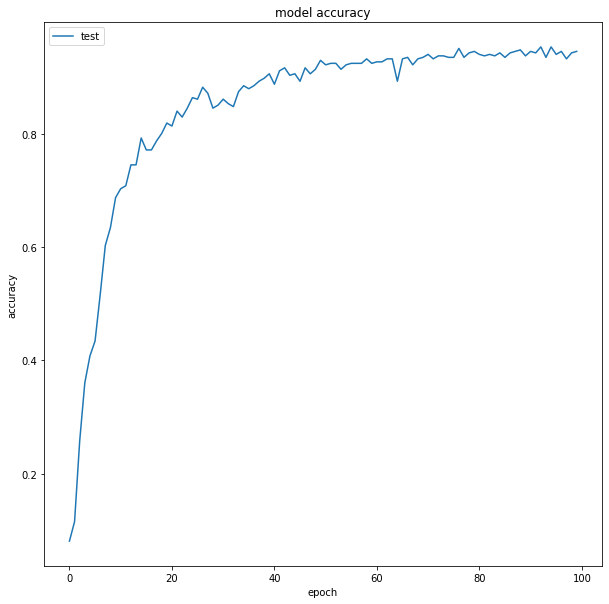

In [ ]:
# Gráfico que muestra la tasa de acierto de los datos de test por cada epoch.
plt.figure(figsize=(10, 10))
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['test'], loc='upper left')
plt.show()

Matriz de Confusión

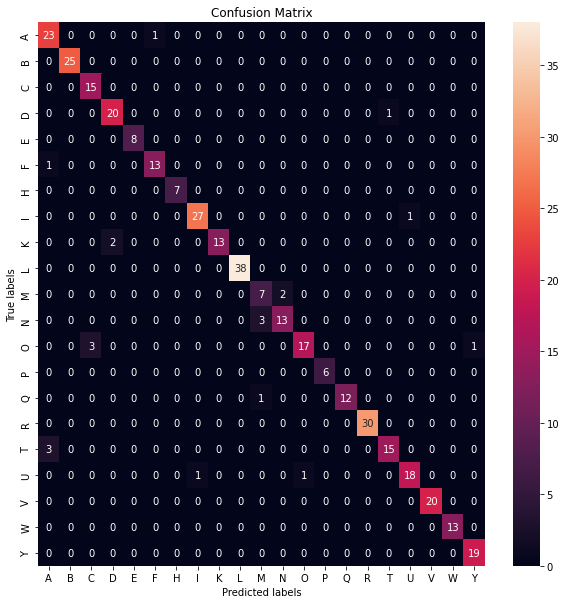

In [ ]:
# Matriz de confusion
Y_prob = modelo.predict(X_test) #Sacamos la matriz de probabilidades 
Y_real = np.argmax(Y_test, axis=1) #Quitamos el One Hot encoding y sacamos el vector de Y
Y_pred = np.argmax(Y_prob, axis=1)  #Lo mismo pero con las predicciones

CM = confusion_matrix(Y_pred, Y_real) #Creamos la matriz de confusión

# Creamos el grafico
plt.figure(figsize=(10, 10))
ax= plt.subplot()
sns.heatmap(CM, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(label_names_sorted); ax.yaxis.set_ticklabels(label_names_sorted);

# 3. Detectar Video

La detección por video está configurada para funcionar en Google Colab.

Para hacer pruebas en local, ejecuta el archivo 'VideoDetection.ipynb'

## Funciones importadas

In [9]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [10]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

## Funcion de detección

In [11]:
# Función que a partir de una imagen, detecta la mano, y predice la letra.
def photo_process(photo_img):
  letra = ''
  acc = ''
  kp, rs, img = process_image(img=photo_img)
  
  if kp is not None:
    Ypr = modelo.predict(kp.reshape(1, 63))
    acc = np.max(Ypr)
    letra = label_names_sorted[np.argmax(Ypr)]
  else:
    img = cv2.flip(img, 1)

  show_prediction(img, letra, f'Acc: {str(acc)}')

## Captura de imagen

<IPython.core.display.Javascript object>

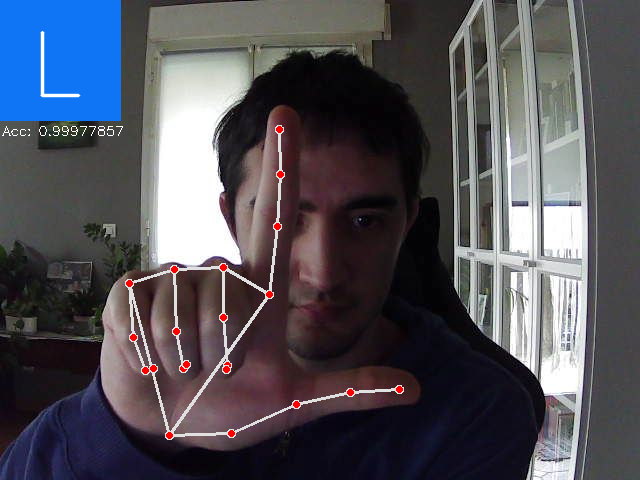

In [12]:
from IPython.display import Image
try:
  filename = take_photo()
  
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

img = cv2.imread('photo.jpg')

photo_process(img)

## Captura de video

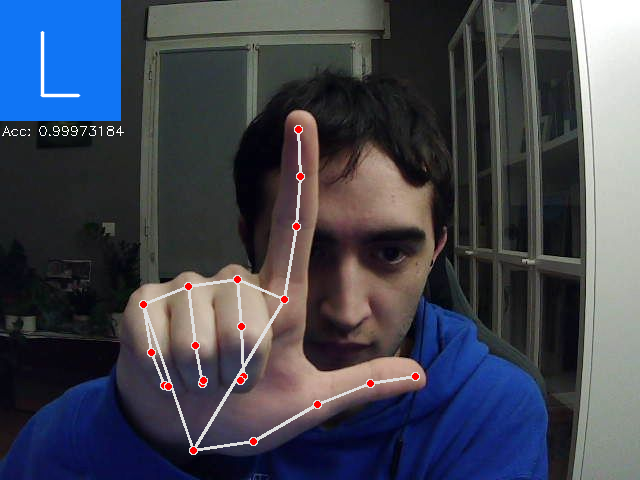

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])
    
    photo_process(img)

    clear_output(wait=True)